# Exploring the Informer model
- The components and how it is made
<img src='data/informer_arch.png' width=300>

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader

import math
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from pandas.tseries.frequencies import to_offset

from datetime import datetime
from data.data_loader import Dataset_Custom

## Encoding of the raw timeseries
- --> into a representation with temporal encoding embedded into the representation

In [2]:
root_path = 'data/'
flag = 'train'  
seq_len, lbl_len, pred_len = 72, 48, 24
size = [seq_len, lbl_len, pred_len]
features = 'MS' # Multivariate feautures IN, Single OUT 
data_path = 'dbank_h.csv'
target = 'close'
scale = True 
inverse = False
timenc = 0 
freq = 'h'
train_data = Dataset_Custom(root_path, flag, size, features, data_path, 
                                          target, scale, inverse, timenc, freq)

In [3]:
# data is processed by window sliding across it
# x will have seq_len length sequence for each of the columns in this case ohlc + vol
# y will have the last lbl_len of seq_len + pred_len 
x, y, x_mark, y_mark = train_data[0]
x.shape, y.shape, x_mark.shape, y_mark.shape

((72, 5), (72, 5), (72, 4), (72, 4))

In [4]:
# x_mark and y_mark are the the timestamp info
# for timenc = 0, no encoding is done, so will have: [month, day, weekday, hour]
x_mark[:3]

array([[ 3,  9,  0, 15],
       [ 3, 10,  1,  8],
       [ 3, 10,  1,  9]])

In [7]:
# setting timenc = 1 --> 'timeF' will encode time between -0.5 to 0.5 
train_data_enc = Dataset_Custom(root_path, flag, size, features, data_path, 
                                          target, scale, inverse, 1, freq)
x, y, x_mark_e, y_mark_e = train_data_enc[0]
x_mark_e[:3]

array([[ 0.15217391, -0.5       , -0.23333333, -0.31369863],
       [-0.15217391, -0.33333333, -0.2       , -0.3109589 ],
       [-0.10869565, -0.33333333, -0.2       , -0.3109589 ]])

In [8]:
# again because freq = 'h' we can see in utils.features.timefeatures 
# that the time features are encoded as: [Hour of day, day of week, day of month, day of year]
# it is encoded to be between -0.5 to 0.5 by following computations:
hourOfDay = lambda x: (x[3]/23.0) - 0.5
dayOfWeek = lambda x: (x[2]/6) - 0.5
dayOfMonth = lambda x: ((x[1] - 1)/30.0) - 0.5
DayOfYear = lambda x: ((x[0] - 1)/ 365) - 0.5 # this is not correct
encode_time = lambda x: torch.tensor([hourOfDay(x), dayOfWeek(x), dayOfMonth(x), DayOfYear(x)])
torch.vstack([encode_time(x_mark[i]) for i in range(3)])

tensor([[ 0.1522, -0.5000, -0.2333, -0.4945],
        [-0.1522, -0.3333, -0.2000, -0.4945],
        [-0.1087, -0.3333, -0.2000, -0.4945]], dtype=torch.float64)

In [9]:
# Correct way
# to get features as day of year we need to use some pandas tools
convert_to_datetime = lambda x: datetime(year=2020, month=x[0], day=x[1], hour=x[3])
dates = pd.to_datetime([convert_to_datetime(x) for x in x_mark])
offset = to_offset('h')
hourOfDay_ = lambda x: (x.hour/23.0) - 0.5
dayOfWeek_ = lambda x: (x.dayofweek/6.0) - 0.5
dayOfMonth_ = lambda x: ((x.day - 1)/30.0) - 0.5
DayOfYearCorrect = lambda x: ((x.dayofyear - 1)/ 365) - 0.5
# trying again now 
encode_time_correct = lambda x: torch.tensor([hourOfDay_(x), dayOfWeek_(x), dayOfMonth_(x), DayOfYearCorrect(x)])
torch.vstack([encode_time_correct(dates[i]) for i in range(3)])

tensor([[ 0.1522, -0.5000, -0.2333, -0.3137],
        [-0.1522, -0.3333, -0.2000, -0.3110],
        [-0.1087, -0.3333, -0.2000, -0.3110]])

### DataEmbedding from models.embed
Forward (x, x_mark)

    - Return: dropout(value_embedding(x) + position_embedding(x) + temporal_embedding(x_mark))


- we explore each of the embeddings

In [14]:
# Reading first sample and wrapping in batch
x, y, x_mark, y_mark = train_data.__getitem__(0)
x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
x_mark = torch.tensor(x_mark, dtype=torch.float32).unsqueeze(0)
y_mark = torch.tensor(y_mark, dtype=torch.float32).unsqueeze(0)
x.shape, y.shape, x_mark.shape, y_mark.shape

(torch.Size([1, 72, 5]),
 torch.Size([1, 72, 5]),
 torch.Size([1, 72, 4]),
 torch.Size([1, 72, 4]))

In [15]:
c_in = x.shape[-1] # number of features in input
d_model = 512 # dimension of the model, matches with n_heads = 8

#### value_embedding = models.embed.TokenEmbedding
- encoding the values of the timeseries (features)

In [16]:
# default it has groups=1, so it is equivalent to Conv1d 
# it will convolve first out_kernel across all in_channels, 
# so all feature map will consider all in_channel
tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, 
                                    kernel_size=3, padding=1, padding_mode='circular')
nn.init.kaiming_normal_(tokenConv.weight,mode='fan_in',nonlinearity='leaky_relu')
# Conv1d input: (batch_size, in_channels, in_length)
x_conv = tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
x_conv.shape

torch.Size([1, 72, 512])

In [18]:
# Checking that the convolution follows the intuition and convolves correctly
x_conv[0,1,0], (x.transpose(1,2)[0, :, :3] * tokenConv.weight[0, :, :]).sum() + tokenConv.bias[0]

(tensor(0.8365, grad_fn=<SelectBackward0>),
 tensor(0.8365, grad_fn=<AddBackward0>))

In [19]:
# Checking the padding circularity, moving last element to the first for padding
x_first_padded = torch.zeros(5,3)
x_first_padded[:, 1:3] = x.transpose(1,2)[0, :, 0:2].clone()
x_first_padded[:, 0] = x.transpose(1,2)[0, :, -1]
x_conv[0,0,0], (x_first_padded * tokenConv.weight[0, :, :]).sum() + tokenConv.bias[0]

(tensor(5.9320, grad_fn=<SelectBackward0>),
 tensor(5.9320, grad_fn=<AddBackward0>))

#### position_embedding = models.embed.PositionEmbedding
- encoding the position of the values on the timeseries (features)

$\text{PE}(pos,2j) = \sin(pos/(2L_x)^{2j/\text{d}_{\text{model}}})$

$\text{PE}(pos,2j+1) = \cos(pos/(2L_x)^{2j/\text{d}_{\text{model}}})$

- pos is position on the timeseries 
- 2j is the dimension of the embedding
- even dimension is sin and odd dimension is cos
- L_x is the length of the timeseries
- d_model is the dimension of the embedding

same as from paper and from the original transformer

In [20]:
# Compute the positional encodings in log space 
max_len = 5000 # L_x from formula
pe = torch.zeros(max_len, d_model).float().requires_grad_(False) # to store the positional encodings
position = torch.arange(0, max_len).unsqueeze(1) # to get the position of each element
div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp() # to get the divisor, 2j

- how can they compute in logspace instead?
- note that $1/2L_x^{2j/d_{\text{model}}}$ is of the form $1/a^{b/c}$

Converting from $1/a^{b/c}$ $\longrightarrow$ $\exp(b * (-\log(a) / c))$

$1/a^{bc}$ = $\exp(\log(1 / a^{b/c}))$ &emsp;&emsp;&emsp; as exp(log) cancels out

= $\exp(-log(a^{b/c}))$   &emsp;&emsp;&emsp; as 1/x = x^(-1) and log(x)^k = k*log(x)

= $\exp(b* -log(a) / c)$   &emsp;&emsp;&emsp; applying again log(x)^k = k*log(x)

hence we get as wanted

In [21]:
position.shape, div_term.shape # div_term is d_model / 2 long as we only need for ever 2nd element

(torch.Size([5000, 1]), torch.Size([256]))

- How to compute the equations?: for each pos, j in Natural numbers s.t.  0 <= pos <= max_len and 0 <= 2j <= d_model
- use broadcasting by position * div_term, will broadcast position across the rows, and the div_term across the columns

In [22]:
# check that computation matches the correct broadcasting intuition
position * div_term == position.repeat(1, d_model // 2) * div_term.repeat(max_len, 1)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [23]:
# now simply compute the sine and cos functions as from formula
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)

pe = pe.unsqueeze(0)
pe.shape

torch.Size([1, 5000, 512])

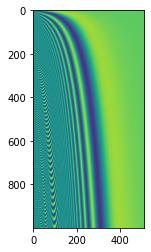

In [24]:
# visualizing the positional encodings
plt.imshow(pe[0,:1000,:].detach().numpy(), cmap='viridis')

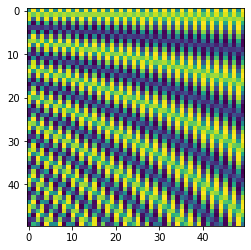

In [26]:
plt.imshow(pe[0,:50,:50].detach().numpy(), cmap='viridis')

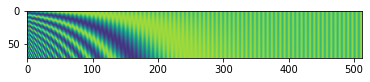

In [27]:
# forward function for pe 
pe[:, :x.size(1)].shape
plt.imshow(pe[0, :x.size(1)], cmap='viridis')

#### temporal_embedding = models.embed.TemporalEmbedding or TimeFeatureEmbedding
- default is TimeFeatureEmbedding
- encoding the temporal features of the timeseries (features)
- we explore first TimeFeatureEmbedding

In [29]:
# Time feature embedding
# we have freq='h' so each time point has 4 values
# simply do linear transform into d_model space
freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
d_inp = freq_map[freq]
embed = nn.Linear(d_inp, d_model)
x_mark_emb = embed(x_mark)
x_mark_emb.shape

torch.Size([1, 72, 512])

- other option is Temporal Embedding, can be either fixed or learned

In [30]:
# Temporal embedding general parameters
minute_size = 4; hour_size = 24
weekday_size = 7; day_size = 32; month_size = 13

In [31]:
# Fixed embedding
# same idea as the positional encodings
# make embedding for each time dimension, hourofday, dayofweek, dayofmonth, dayofyear
class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

In [32]:
# how to forward the two embedding types fixed or learned
Embed = FixedEmbedding if True else nn.Embedding
hour_embed = Embed(hour_size, d_model)
weekday_embed = Embed(weekday_size, d_model)
day_embed = Embed(day_size, d_model)
month_embed = Embed(month_size, d_model)

In [33]:
x_mark = x_mark.long()
hour_x = hour_embed(x_mark[:,:,3])
weekday_x = weekday_embed(x_mark[:,:,2])
day_x = day_embed(x_mark[:,:,1])
month_x = month_embed(x_mark[:,:,0])
encoded_time = hour_x + weekday_x + day_x + month_x # combine all the embeddings
encoded_time.shape

torch.Size([1, 72, 512])

- at last, all embeddings will be summed together and then dropout will be applied
- decoder embedding is exact same technique it will just of course have separate weights, so instantiate other class

## Next step: is the informer encoder
- Encoder([encoder_layers, Conv_layers, layerNorm])
- It n encoder_layers, for example 4 
- each encoder layer, has:
    - x = EncoderLayer(ProbSparseAttention(x))
    - x = ConvLayer(X) # because distil=True
- After all encoder layers it will do 
    - x = LayerNorm(x)

__ProbSparseAttention__:

In [34]:
# is encapsulated in attentionLayer
# parameters in attentionLayer
n_heads = 8
assert d_model % n_heads == 0
d_keys = (d_model//n_heads)
d_values = (d_model//n_heads)

#inner_attention = attention # the ProbSparseAttention class
query_projection = nn.Linear(d_model, d_keys * n_heads)
key_projection = nn.Linear(d_model, d_keys * n_heads)
value_projection = nn.Linear(d_model, d_values * n_heads)
out_projection = nn.Linear(d_values * n_heads, d_model)
n_heads = n_heads
mix = False # mix attention only used for first decoder ProbsparseAttention

In [36]:
# Forward
# it is self attention so 
x = torch.rand(1, seq_len, d_model)
queries = x 
keys = x
values = x
B, L, _ = queries.shape
_, S, _ = keys.shape
H = n_heads

queries = query_projection(queries).view(B, L, H, -1)
keys = key_projection(keys).view(B, S, H, -1)
values = value_projection(values).view(B, S, H, -1)

# below we should use Probsparseattention instead
# out, attn = self.inner_attention(
#     queries,
#     keys,
#     values,
#     attn_mask
# )

# if mix:
#     out = out.transpose(2,1).contiguous()
# out = out.view(B, L, -1)

# return self.out_projection(out), attn

In [37]:
# the ProbSparseAttention 
# parameters
factor = 5 # the C factor from the paper, number of queris = factor*log(L) 
scale = scale
mask_flag = False
output_attention = False
dropout = nn.Dropout(0)

In [64]:
# the ProbSparseForward function for the encoder
# input: queries = keys = values = x, attn_mask = None
B, L_Q, H, D = queries.shape
_, L_K, _, _ = keys.shape # L_K can be different from L_Q in decoder 

queries = queries.transpose(2,1) # B, L_Q, H, D -> B, H, L_Q, D because we want to do dot products across the time steps
keys = keys.transpose(2,1)
values = values.transpose(2,1)

# sampling factors as from the paper
U_part = factor * np.ceil(np.log(L_K)).astype('int').item() # c*ln(L_k)
u = factor * np.ceil(np.log(L_Q)).astype('int').item() # c*ln(L_q) 

# sanity check 
U_part = U_part if U_part<L_K else L_K
u = u if u<L_Q else L_Q

# Use helper function _prob_QK to sample top queries as from the paper
# defined below
scores_top, index = _prob_QK(queries, keys, sample_k=U_part, n_top=u) 

# add scale factor
scale = None
scale = scale or 1./math.sqrt(D)
if scale is not None:
    scores_top = scores_top * scale

#Use helper function _get_initial_context, explained below and also defined below
# get the context
# context = _get_initial_context(values, L_Q)
# # update the context with selected top_k queries
# context, attn = _update_context(context, values, scores_top, index, L_Q, attn_mask=None)

# context.transpose(2,1).contiguous(), attn # return

In [39]:
Q = queries; K = keys; sample_k = U_part; n_top=u; 

B, H, L_K, E = K.shape
_, _, L_Q, _ = Q.shape

In [40]:
# calculate the sampled Q_K
K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)

index_sample = torch.randint(L_K, (L_Q, sample_k)) # real U = U_part(factor*ln(L_k))*L_q

K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]

index_sample.shape, K_expand.shape, K_sample.shape

(torch.Size([72, 25]),
 torch.Size([1, 8, 72, 72, 64]),
 torch.Size([1, 8, 72, 25, 64]))

In [ ]:
# sample sample_k number of keys to dot product with all query as from paper
# note for each query it will sample sample_k number of different keys
K[:,:,index_sample[0]] == K_sample[:,:,0,:,:]

In [45]:
# compute the dot products for each query on to all the sampled keys
Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)
Q_K_sample.shape

torch.Size([1, 8, 72, 25])

In [55]:
# find the Top_k query with sparisty measurement
M =  Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)

In [56]:
M_top = M.topk(n_top, sorted=False)[1]

# use the reduced Q to calculate Q_K
Q_reduce = Q[torch.arange(B)[:, None, None],
                torch.arange(H)[None, :, None],
                M_top, :] # factor*ln(L_q)
Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1)) # factor*ln(L_q)*L_k
Q_K.shape

torch.Size([1, 8, 25, 72])

In [62]:
# wrapping up the _prob_QK function
# apply function above in the attention cell and then continue with next part in next cell
# Q [B, H, L, D]
def _prob_QK(Q, K, sample_k=None, n_top=None):
    B, H, L_K, E = K.shape
    _, _, L_Q, _ = Q.shape

    # calculate the sampled Q_K
    K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
    index_sample = torch.randint(L_K, (L_Q, sample_k)) # real U = U_part(factor*ln(L_k))*L_q
    K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
    Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)

    # find the Top_k query with sparisty measurement
    M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
    M_top = M.topk(n_top, sorted=False)[1]

    # use the reduced Q to calculate Q_K
    Q_reduce = Q[torch.arange(B)[:, None, None],
                    torch.arange(H)[None, :, None],
                    M_top, :] # factor*ln(L_q)

    Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1)) # factor*ln(L_q)*L_k

    return Q_K, M_top

In [69]:
# explaining get context + defining
# context is as from the paper
# it is simpler computation of all the queries which get uniform distribution over the keys
# these will result in close to just computing the mean of the values, hence the context is proxy for that
def _get_initial_context(values, L_Q):
    V = values
    mask_flag = False
    B, H, L_V, D = V.shape
    if not mask_flag:
        # V_sum = V.sum(dim=-2)
        V_sum = V.mean(dim=-2)  
        contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        # contex[0, :, 1, :] == V_sum[0, :, :]
    else: # use mask
        assert(L_Q == L_V) # requires that L_Q == L_V, i.e. for self-attention only
        contex = V.cumsum(dim=-2)
    return contex 